# Assignment Module 2: Product Classification

The goal of this assignment is to implement a neural network that classifies smartphone pictures of products found in grocery stores. The assignment will be divided into two parts: first, you will be asked to implement from scratch your own neural network for image classification; then, you will fine-tune a pretrained network provided by PyTorch.


## Preliminaries: the dataset

The dataset you will be using contains natural images of products taken with a smartphone camera in different grocery stores:

<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Granny-Smith.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Pink-Lady.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Lemon.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Banana.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Vine-Tomato.jpg" width="150">
</p>
<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Yellow-Onion.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Green-Bell-Pepper.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Arla-Standard-Milk.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Oatly-Natural-Oatghurt.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Alpro-Fresh-Soy-Milk.jpg" width="150">
</p>

The products belong to the following 43 classes:
```
0.  Apple
1.  Avocado
2.  Banana
3.  Kiwi
4.  Lemon
5.  Lime
6.  Mango
7.  Melon
8.  Nectarine
9.  Orange
10. Papaya
11. Passion-Fruit
12. Peach
13. Pear
14. Pineapple
15. Plum
16. Pomegranate
17. Red-Grapefruit
18. Satsumas
19. Juice
20. Milk
21. Oatghurt
22. Oat-Milk
23. Sour-Cream
24. Sour-Milk
25. Soyghurt
26. Soy-Milk
27. Yoghurt
28. Asparagus
29. Aubergine
30. Cabbage
31. Carrots
32. Cucumber
33. Garlic
34. Ginger
35. Leek
36. Mushroom
37. Onion
38. Pepper
39. Potato
40. Red-Beet
41. Tomato
42. Zucchini
```

The dataset is split into training (`train`), validation (`val`), and test (`test`) set.

The following code cells download the dataset and define a `torch.utils.data.Dataset` class to access it. This `Dataset` class will be the starting point of your assignment: use it in your own code and build everything else around it.

In [1]:
!git clone https://github.com/marcusklasson/GroceryStoreDataset.git

Cloning into 'GroceryStoreDataset'...
remote: Enumerating objects: 6559, done.
remote: Counting objects: 100% (266/266), done.
remote: Compressing objects: 100% (231/231), done.
remote: Total 6559 (delta 45), reused 35 (delta 35), pack-reused 6293 (from 1)
Receiving objects: 100% (6559/6559), 116.26 MiB | 15.07 MiB/s, done.
Resolving deltas: 100% (275/275), done.
Updating files: 100% (5717/5717), done.


In [3]:
from pathlib import Path
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset
from typing import List, Tuple

In [4]:
class GroceryStoreDataset(Dataset):

    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("GroceryStoreDataset/dataset")
        self.split = split
        self.paths, self.labels = self.read_file()
        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img = Image.open(self.root / self.paths[idx])
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def read_file(self) -> Tuple[List[str], List[int]]:
        paths = []
        labels = []

        with open(self.root / f"{self.split}.txt") as f:
            for line in f:
                # path, fine-grained class, coarse-grained class
                path, _, label = line.replace("\n", "").split(", ")
                paths.append(path), labels.append(int(label))

        return paths, labels

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

## Part 1: design your own network

Your goal is to implement a convolutional neural network for image classification and train it on `GroceryStoreDataset`. You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split of **around 60%**. You are free to achieve that however you want, except for a few rules you must follow:

- You **cannot** simply instantiate an off-the-self PyTorch network. Instead, you must construct your network as a composition of existing PyTorch layers. In more concrete terms, you can use e.g. `torch.nn.Linear`, but you **cannot** use e.g. `torchvision.models.alexnet`.

- Justify every *design choice* you make. Design choices include network architecture, training hyperparameters, and, possibly, dataset preprocessing steps. You can either (i) start from the simplest convolutional network you can think of and add complexity one step at a time, while showing how each step gets you closer to the target ~60%, or (ii) start from a model that is already able to achieve the desired accuracy and show how, by removing some of its components, its performance drops (i.e. an *ablation study*). You can *show* your results/improvements however you want: training plots, console-printed values or tables, or whatever else your heart desires: the clearer, the better.

Don't be too concerned with your network performance: the ~60% is just to give you an idea of when to stop. Keep in mind that a thoroughly justified model with lower accuracy will be rewarded **more** points than a poorly experimentally validated model with higher accuracy.

In [5]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm

from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import transforms as T

import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [6]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Device: {device}")

Device: cuda


Training set size:  2640
Validation set size:  296
Test set size:  2485


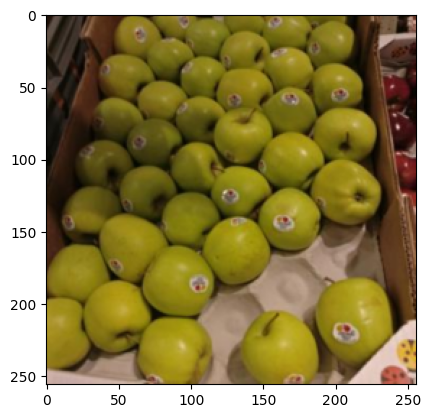

In [7]:
transform_train = T.Compose([
		 T.Resize((256, 256)),
		 T.RandomHorizontalFlip(),
		 T.ToTensor(),
])

transform_test = T.Compose([
		 T.Resize((256, 256)),
		 T.ToTensor(),
])

train_dset = GroceryStoreDataset(split='train', transform=transform_train)
val_dset = GroceryStoreDataset(split='val', transform=transform_test)
test_dset = GroceryStoreDataset(split='test', transform=transform_test)
n_classes = 43

x, y = train_dset[17]
print("Training set size: ", len(train_dset))
print("Validation set size: ", len(val_dset))
print("Test set size: ", len(test_dset))
plt.imshow(x.permute(1, 2, 0))
plt.show()

In [9]:
batch_size = 256

train_dl = DataLoader(
    train_dset,
    batch_size=batch_size,
    shuffle=True
)
val_dl = DataLoader(
    val_dset,
    batch_size=batch_size,
)
test_dl = DataLoader(
    test_dset,
    batch_size=batch_size
)

In [10]:
class SimpleClassifier(nn.Module):
    def __init__(self, n_classes):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 256 -> 128

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 128 -> 64

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 64 -> 32

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 32 -> 16

            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))  # Output size: 1x1
        )

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(512, n_classes)
        )


    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [12]:
model = SimpleClassifier(
    n_classes,
)

# Push model to device. Has to be done only once.
model.to(device)

SimpleClassifier(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=

In [14]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3)

In [15]:
def ncorrect(scores, y):
    y_hat = torch.argmax(scores, -1)
    return (y_hat == y).sum()

def accuracy(scores, y):
    correct = ncorrect(scores, y)
    return correct.true_divide(y.shape[0])

def train_loop(model, train_dl, epochs, opt, scheduler, val_dl=None, verbose=False):
    best_val_acc = 0
    best_params = []
    best_epoch = -1

    for e in tqdm(range(epochs)):
        model.train()
        # Train
        train_loss = 0
        train_samples = 0
        train_acc = 0
        for train_data in train_dl:
            imgs = train_data[0].to(device)
            labels = train_data[1].to(device)
            scores = model(imgs)
            loss = F.cross_entropy(scores, labels)
            train_loss += loss.item() * imgs.shape[0]
            train_samples += imgs.shape[0]
            train_acc += ncorrect(scores, labels).item()

            opt.zero_grad()  # clear
            loss.backward()  # fill
            opt.step()       # use

        train_acc /= train_samples
        train_loss /= train_samples

        # Validation
        model.eval()
        with torch.no_grad():
            val_loss = 0
            val_samples = 0
            val_acc = 0
            if val_dl is not None:
                for val_data in val_dl:
                    imgs = val_data[0].to(device)
                    labels = val_data[1].to(device)
                    val_scores = model(imgs)
                    val_loss += F.cross_entropy(val_scores, labels).item() * imgs.shape[0]
                    val_samples += imgs.shape[0]
                    val_acc += ncorrect(val_scores, labels).item()
                val_acc /= val_samples
                val_loss /= val_samples

                scheduler.step(val_loss)

            if val_dl is None or val_acc > best_val_acc:
                best_val_acc = val_acc if val_dl is not None else 0
                best_params = model.state_dict()
                torch.save(best_params, "best_model.pth")
                best_epoch = e

        if verbose and e % 5 == 0:
            print(f"Epoch {e}: train loss {train_loss:.3f} - train acc {train_acc:.3f}" + ("" if val_dl is None else f" - valid loss {val_loss:.3f} - valid acc {val_acc:.3f}"))

    if verbose and val_dl is not None:
        print(f"Best epoch {best_epoch}, best acc {best_val_acc}")

    return best_val_acc, best_params, best_epoch

In [16]:
epochs = 20

best_val_acc, best_params, best_epoch = train_loop(
    model,
    train_dl,
    epochs,
    optimizer,
    scheduler,
    val_dl,
    verbose=True
)

  5%|▌         | 1/20 [00:16<05:14, 16.57s/it]

Epoch 0: train loss 2.742 - train acc 0.278 - valid loss 3.956 - valid acc 0.068


 30%|███       | 6/20 [01:30<03:26, 14.71s/it]

Epoch 5: train loss 1.210 - train acc 0.645 - valid loss 1.896 - valid acc 0.405


 55%|█████▌    | 11/20 [02:41<02:08, 14.32s/it]

Epoch 10: train loss 0.771 - train acc 0.791 - valid loss 1.571 - valid acc 0.500


 80%|████████  | 16/20 [03:53<00:57, 14.30s/it]

Epoch 15: train loss 0.512 - train acc 0.868 - valid loss 1.704 - valid acc 0.510


100%|██████████| 20/20 [04:50<00:00, 14.50s/it]

Best epoch 18, best acc 0.6317567567567568


# Ablation

## Ablation of deeper layers
This ablation study removes the deeper layers (with 256 and 512 filters) from the model, keeping only the shallower convolutional layers. This helps to assess how important the deeper layers are for the model's performance.

In [17]:
class SimpleClassifier_no_deep(nn.Module):
  def __init__(self, n_classes):
    super().__init__()

    self.features = nn.Sequential(
        nn.Conv2d(3, 32, 3, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2, 2),  # 256 -> 128

        nn.Conv2d(32, 64, 3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2, 2),  # 128 -> 64

        nn.Conv2d(64, 128, 3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2, 2)  # 64 -> 32

        # Removed the deeper layers (blocks with 256 and 512 filters)
    )

    # Adjusted classifier for reduced feature size
    self.classifier = nn.Sequential(
        nn.Linear(128 * 32 * 32, n_classes)  # Adjusted input size
    )

  def forward(self, x):
    x = self.features(x)
    x = x.view(x.size(0), -1)  # Flatten the output
    x = self.classifier(x)
    return x

model_no_deep = SimpleClassifier_no_deep(
    n_classes,
)

# Push model to device. Has to be done only once.
model_no_deep.to(device)

optimizer_no_deep = Adam(model_no_deep.parameters(), lr=0.001)
scheduler_no_deep = ReduceLROnPlateau(optimizer_no_deep, 'min', patience=3)

best_val_acc_no_deep, best_params_no_deep, best_epoch_no_deep = train_loop(
    model_no_deep,
    train_dl,
    epochs,
    optimizer_no_deep,
    scheduler_no_deep,
    val_dl,
    verbose=True
)

  5%|▌         | 1/20 [00:13<04:19, 13.66s/it]

Epoch 0: train loss 87.776 - train acc 0.097 - valid loss 36.583 - valid acc 0.030


 30%|███       | 6/20 [01:23<03:15, 14.00s/it]

Epoch 5: train loss 2.849 - train acc 0.646 - valid loss 7.328 - valid acc 0.280


 55%|█████▌    | 11/20 [02:32<02:04, 13.80s/it]

Epoch 10: train loss 1.025 - train acc 0.842 - valid loss 7.430 - valid acc 0.277


 80%|████████  | 16/20 [03:43<00:56, 14.10s/it]

Epoch 15: train loss 0.331 - train acc 0.931 - valid loss 7.770 - valid acc 0.334


100%|██████████| 20/20 [04:40<00:00, 14.04s/it]

Best epoch 15, best acc 0.3344594594594595


Removing the deeper convolutional layers (256, 512) significantly reduced the validation accuracy to 33.4%, showing that deeper layers contribute to feature extraction, even if they might increase model complexity

When the deeper layers (256 and 512 filters) were removed, there was a substantial drop in accuracy. This indicates that the deeper layers are essential for capturing more complex, high-level features.

## Dropout Ablation

This ablation removes the `Dropout(p=0.5)` from the classifier. Dropout is used to prevent overfitting, and by removing it, we can assess whether the model overfits to the training data

In [18]:
class SimpleClassifier_no_dropout(nn.Module):
    def __init__(self, n_classes):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 256 -> 128

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 128 -> 64

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 64 -> 32

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 32 -> 16

            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))  # Output size: 1x1
        )

        # Removed the dropout in the classifier
        self.classifier = nn.Sequential(
            nn.Linear(512, n_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.classifier(x)
        return x


model_no_dropout = SimpleClassifier_no_dropout(n_classes)

# Push model to device. Has to be done only once.
model_no_dropout.to(device)

optimizer_no_dropout = Adam(model_no_dropout.parameters(), lr=0.001)
scheduler_no_dropout = ReduceLROnPlateau(optimizer_no_dropout, 'min', patience=3)


best_val_acc_no_dropout, best_params_no_dropout, best_epoch_no_dropout = train_loop(
    model_no_dropout,
    train_dl,
    epochs,
    optimizer_no_dropout,
    scheduler_no_dropout,
    val_dl,
    verbose=True
)

  5%|▌         | 1/20 [00:15<04:52, 15.40s/it]

Epoch 0: train loss 2.682 - train acc 0.296 - valid loss 4.013 - valid acc 0.068


 30%|███       | 6/20 [01:29<03:25, 14.64s/it]

Epoch 5: train loss 1.043 - train acc 0.720 - valid loss 1.936 - valid acc 0.426


 55%|█████▌    | 11/20 [02:43<02:12, 14.73s/it]

Epoch 10: train loss 0.549 - train acc 0.872 - valid loss 1.771 - valid acc 0.493


 80%|████████  | 16/20 [04:00<00:59, 14.95s/it]

Epoch 15: train loss 0.314 - train acc 0.940 - valid loss 1.970 - valid acc 0.426


100%|██████████| 20/20 [04:59<00:00, 14.96s/it]

Best epoch 16, best acc 0.6047297297297297


Without dropout, the model's best accuracy was 60.5%. While slightly worse than the full model, it suggests dropout helps combat overfitting but isn't the sole reason for good performance.

## Optimizer Ablation (Changing to SGD)

This ablation changes the optimizer from `Adam` to `SGD`. Adam uses adaptive learning rates for each parameter, while SGD uses a single learning rate and momentum. This helps test if Adam’s adaptive learning rate strategy is crucial for convergence.

In [19]:
from torch.optim import SGD

model_sgd = SimpleClassifier(n_classes)

# Push model to device. Has to be done only once.
model_sgd.to(device)

optimizer_sgd = SGD(model_sgd.parameters(), lr=0.001, momentum=0.9)
scheduler_sgd = ReduceLROnPlateau(optimizer_sgd, 'min', patience=3)


best_val_acc_sgd, best_params_sgd, best_epoch_sgd = train_loop(
    model_sgd,
    train_dl,
    epochs,
    optimizer_sgd,
    scheduler_sgd,
    val_dl,
    verbose=True
)


  5%|▌         | 1/20 [00:15<04:51, 15.32s/it]

Epoch 0: train loss 3.806 - train acc 0.016 - valid loss 3.759 - valid acc 0.017


 30%|███       | 6/20 [01:30<03:30, 15.07s/it]

Epoch 5: train loss 2.772 - train acc 0.294 - valid loss 2.913 - valid acc 0.260


 55%|█████▌    | 11/20 [02:49<02:22, 15.78s/it]

Epoch 10: train loss 2.437 - train acc 0.372 - valid loss 2.631 - valid acc 0.331


 80%|████████  | 16/20 [04:05<01:01, 15.48s/it]

Epoch 15: train loss 2.215 - train acc 0.412 - valid loss 2.462 - valid acc 0.378


100%|██████████| 20/20 [05:07<00:00, 15.36s/it]

Best epoch 15, best acc 0.3783783783783784


Using SGD instead of Adam achieved a best validation accuracy of 37.8%. Adam's adaptive learning rate likely helps the model converge faster.

In [20]:
def train_loop_no_scheduler(model, train_dl, epochs, opt, val_dl=None, verbose=False):
    best_val_acc = 0
    best_params = []
    best_epoch = -1

    for e in tqdm(range(epochs)):
        model.train()
        # Train
        train_loss = 0
        train_samples = 0
        train_acc = 0
        for train_data in train_dl:
            imgs = train_data[0].to(device)
            labels = train_data[1].to(device)
            scores = model(imgs)
            loss = F.cross_entropy(scores, labels)
            train_loss += loss.item() * imgs.shape[0]
            train_samples += imgs.shape[0]
            train_acc += ncorrect(scores, labels).item()

            opt.zero_grad()  # clear
            loss.backward()  # fill
            opt.step()       # use

        train_acc /= train_samples
        train_loss /= train_samples

        # Validation
        model.eval()
        with torch.no_grad():
            val_loss = 0
            val_samples = 0
            val_acc = 0
            if val_dl is not None:
                for val_data in val_dl:
                    imgs = val_data[0].to(device)
                    labels = val_data[1].to(device)
                    val_scores = model(imgs)
                    val_loss += F.cross_entropy(val_scores, labels).item() * imgs.shape[0]
                    val_samples += imgs.shape[0]
                    val_acc += ncorrect(val_scores, labels).item()
                val_acc /= val_samples
                val_loss /= val_samples

            if val_dl is None or val_acc > best_val_acc:
                best_val_acc = val_acc if val_dl is not None else 0
                best_params = model.state_dict()
                torch.save(best_params, "best_model.pth")
                best_epoch = e

        if verbose and e % 5 == 0:
            print(f"Epoch {e}: train loss {train_loss:.3f} - train acc {train_acc:.3f}" + ("" if val_dl is None else f" - valid loss {val_loss:.3f} - valid acc {val_acc:.3f}"))

    if verbose and val_dl is not None:
        print(f"Best epoch {best_epoch}, best acc {best_val_acc}")

    return best_val_acc, best_params, best_epoch

model_no_scheduler = SimpleClassifier(
    n_classes,
)

# Push model to device. Has to be done only once.
model_no_scheduler.to(device)

optimizer_no_scheduler = Adam(model_no_scheduler.parameters(), lr=0.001)

best_val_acc_no_scheduler, best_params_no_scheduler, best_epoch_no_scheduler = train_loop_no_scheduler(
    model_no_scheduler,
    train_dl,
    epochs,
    optimizer_no_scheduler,
    val_dl,
    verbose=True
)

  5%|▌         | 1/20 [00:14<04:42, 14.85s/it]

Epoch 0: train loss 2.780 - train acc 0.288 - valid loss 3.888 - valid acc 0.068


 30%|███       | 6/20 [01:30<03:32, 15.15s/it]

Epoch 5: train loss 1.184 - train acc 0.667 - valid loss 2.220 - valid acc 0.358


 55%|█████▌    | 11/20 [02:45<02:14, 14.96s/it]

Epoch 10: train loss 0.721 - train acc 0.811 - valid loss 1.855 - valid acc 0.405


 80%|████████  | 16/20 [04:01<01:00, 15.09s/it]

Epoch 15: train loss 0.453 - train acc 0.893 - valid loss 1.644 - valid acc 0.541


100%|██████████| 20/20 [05:01<00:00, 15.07s/it]

Best epoch 17, best acc 0.6081081081081081


# Ablation of Batch Normalization

This ablation removes all `BatchNorm2d` layers from the model. Batch normalization helps to stabilize the training by normalizing activations during training.

In [21]:
class SimpleClassifier_no_bn(nn.Module):
    def __init__(self, n_classes):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 256 -> 128

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 128 -> 64

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 64 -> 32

            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 32 -> 16

            nn.Conv2d(256, 512, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))  # Output size: 1x1
        )

        self.classifier = nn.Sequential(
            nn.Linear(512, n_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


model_no_bn = SimpleClassifier_no_bn(
    n_classes,
)

# Push model to device. Has to be done only once.
model_no_bn.to(device)

optimizer_no_bn = Adam(model_no_bn.parameters(), lr=0.001)
scheduler_no_bn = ReduceLROnPlateau(optimizer_no_bn, 'min', patience=3)

best_val_acc_no_bn, best_params_no_bn, best_epoch_no_bn = train_loop(
    model_no_bn,
    train_dl,
    epochs,
    optimizer_no_bn,
    scheduler_no_bn,
    val_dl,
    verbose=True
)

  5%|▌         | 1/20 [00:13<04:17, 13.57s/it]

Epoch 0: train loss 3.648 - train acc 0.073 - valid loss 3.655 - valid acc 0.068


 30%|███       | 6/20 [01:21<03:09, 13.51s/it]

Epoch 5: train loss 3.403 - train acc 0.105 - valid loss 3.493 - valid acc 0.074


 55%|█████▌    | 11/20 [02:29<02:03, 13.73s/it]

Epoch 10: train loss 3.359 - train acc 0.105 - valid loss 3.478 - valid acc 0.074


 80%|████████  | 16/20 [03:38<00:54, 13.58s/it]

Epoch 15: train loss 3.219 - train acc 0.157 - valid loss 3.329 - valid acc 0.172


100%|██████████| 20/20 [04:31<00:00, 13.59s/it]

Best epoch 15, best acc 0.17229729729729729


## Part 2: fine-tune an existing network

Your goal is to fine-tune a pretrained **ResNet-18** model on `GroceryStoreDataset`. Use the implementation provided by PyTorch, do not implement it yourselves! (i.e. exactly what you **could not** do in the first part of the assignment). Specifically, you must use the PyTorch ResNet-18 model pretrained on ImageNet-1K (V1). Divide your fine-tuning into two parts:

1. First, fine-tune the Resnet-18 with the same training hyperparameters you used for your best model in the first part of the assignment.
1. Then, tweak the training hyperparameters in order to increase the accuracy on the validation split of `GroceryStoreDataset`. Justify your choices by analyzing the training plots and/or citing sources that guided you in your decisions (papers, blog posts, YouTube videos, or whatever else you find enlightening). You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split **between 80 and 90%**.

In [24]:
import torchvision.models as models

In [25]:
transform = T.Compose([
		 T.Resize((224, 224)),
		 T.RandomHorizontalFlip(),
		 T.ToTensor(),
])

In [27]:
model = models.resnet18(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, n_classes)
model = model.to(device)

optimizer = Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3)

In [28]:
epochs = 20  # Same as in Part 1

best_val_acc, best_params, best_epoch = train_loop(
    model,
    train_dl,
    epochs,
    optimizer,
    scheduler,
    val_dl,
    verbose=True
)

  5%|▌         | 1/20 [00:14<04:44, 14.97s/it]

Epoch 0: train loss 1.271 - train acc 0.688 - valid loss 2.377 - valid acc 0.382


 30%|███       | 6/20 [01:27<03:23, 14.55s/it]

Epoch 5: train loss 0.037 - train acc 0.990 - valid loss 1.958 - valid acc 0.568


 55%|█████▌    | 11/20 [02:38<02:08, 14.24s/it]

Epoch 10: train loss 0.007 - train acc 1.000 - valid loss 0.782 - valid acc 0.777


 80%|████████  | 16/20 [03:50<00:56, 14.22s/it]

Epoch 15: train loss 0.004 - train acc 1.000 - valid loss 0.742 - valid acc 0.774


100%|██████████| 20/20 [04:47<00:00, 14.35s/it]

Best epoch 3, best acc 0.793918918918919


In [31]:
model.eval()
x, y = test_dset[800]
print(f"Etichetta reale: {y}")

input_tensor = x.unsqueeze(0).to(device)

with torch.no_grad():
    output = model(input_tensor)


probabilities = torch.nn.functional.softmax(output[0], dim=0)

predicted_class = torch.argmax(probabilities).item()

class_names = [
    "Apple", "Avocado", "Banana", "Kiwi", "Lemon", "Lime", "Mango", "Melon",
    "Nectarine", "Orange", "Papaya", "Passion-Fruit", "Peach", "Pear",
    "Pineapple", "Plum", "Pomegranate", "Red-Grapefruit", "Satsumas", "Juice",
    "Milk", "Oatghurt", "Oat-Milk", "Sour-Cream", "Sour-Milk", "Soyghurt",
    "Soy-Milk", "Yoghurt", "Asparagus", "Aubergine", "Cabbage", "Carrots",
    "Cucumber", "Garlic", "Ginger", "Leek", "Mushroom", "Onion", "Pepper",
    "Potato", "Red-Beet", "Tomato", "Zucchini"
]

print(f"La classe prevista è: {class_names[predicted_class]} (indice {predicted_class})")
print(f"Probabilità: {probabilities[predicted_class].item() * 100:.2f}%")

Etichetta reale: 12
La classe prevista è: Peach (indice 12)
Probabilità: 98.87%
